# Logistic Regression esimerkki

Vedenkulutusennuste
Tavoitteena ennustaa vedenkulutus

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score

# Logistic regression esimerkki aivoinfarktitapausten ennustamiseksi. 

# read data (replace with your own path)
df = pd.read_csv(r'C:\Users\karil\Personal\Python\Prophet\M3.csv', sep=';')
df.head(10)



,Paiva,Kuukausi,Viikko,vpnimi,Tunti,Vedenkulutus,yli_alle
0,23,5,21,to,1,0.00,1
1,23,5,21,to,2,0.02,1
2,23,5,21,to,3,0.04,0
3,23,5,21,to,4,0.04,0
4,24,5,21,pe,1,0.00,1
5,24,5,21,pe,2,0.01,1
6,24,5,21,pe,3,0.04,0
7,24,5,21,pe,4,0.05,0
8,25,5,21,la,1,0.06,0
9,25,5,21,la,2,0.02,1


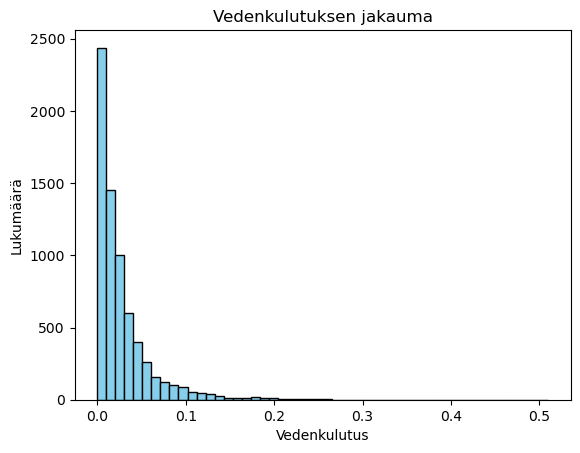

In [2]:
import matplotlib.pyplot as plt
# Piirrä histogrammi 'Vedenkulutus'-sarakkeesta
plt.hist(df['Vedenkulutus'], bins=50, color='skyblue', edgecolor='black')

# Lisää otsikko ja akselien nimet
plt.title('Vedenkulutuksen jakauma')
plt.xlabel('Vedenkulutus')
plt.ylabel('Lukumäärä')

# Näytä histogrammi
plt.show()

In [3]:
df.dropna()
df.drop_duplicates()
df.drop(['Vedenkulutus'],axis=1,inplace=True)
df.shape

(6899, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6899 entries, 0 to 6898
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Paiva     6899 non-null   int64 
 1   Kuukausi  6899 non-null   int64 
 2   Viikko    6899 non-null   int64 
 3   vpnimi    6899 non-null   object
 4   Tunti     6899 non-null   int64 
 5   yli_alle  6899 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 323.5+ KB


In [5]:
df.columns

Index(['Paiva', 'Kuukausi', 'Viikko', 'vpnimi', 'Tunti', 'yli_alle'], dtype='object')

In [6]:
numeric = [column for column in df.columns if df[column].dtype in ['int64','float64']]
print(numeric)

['Paiva', 'Kuukausi', 'Viikko', 'Tunti', 'yli_alle']


In [7]:
categorical = [column for column in df.columns if df[column].dtype == 'O']
print(categorical)

['vpnimi']


In [8]:
# muutetaan viikonpäivän nimet hot_encoden avulla
from sklearn.preprocessing import OneHotEncoder

# Valitaan kategorinen muuttuja
categorical_columns = ['vpnimi']

# Luo OneHotEncoder-instanssi
encoder = OneHotEncoder()

# Sovita encoder dataan ja muunna se one hot encoding -muotoon
encoded_data = encoder.fit_transform(df[categorical_columns])

# Muunna sparse matrix DataFrameksi
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Yhdistä uusi DataFrame alkuperäiseen DataFrameen, asettaen 'yli_alle' sarakkeen viimeiseksi
df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Tulosta uusi DataFrame

print(df_encoded.head())

   Paiva  Kuukausi  Viikko  Tunti  yli_alle  vpnimi_ke  vpnimi_la  vpnimi_ma  \
0     23         5      21      1         1        0.0        0.0        0.0   
1     23         5      21      2         1        0.0        0.0        0.0   
2     23         5      21      3         0        0.0        0.0        0.0   
3     23         5      21      4         0        0.0        0.0        0.0   
4     24         5      21      1         1        0.0        0.0        0.0   

   vpnimi_pe  vpnimi_su  vpnimi_ti  vpnimi_to  
0        0.0        0.0        0.0        1.0  
1        0.0        0.0        0.0        1.0  
2        0.0        0.0        0.0        1.0  
3        0.0        0.0        0.0        1.0  
4        1.0        0.0        0.0        0.0  


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6899 entries, 0 to 6898
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Paiva     6899 non-null   int64 
 1   Kuukausi  6899 non-null   int64 
 2   Viikko    6899 non-null   int64 
 3   vpnimi    6899 non-null   object
 4   Tunti     6899 non-null   int64 
 5   yli_alle  6899 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 323.5+ KB


In [10]:
df_encoded.columns

Index(['Paiva', 'Kuukausi', 'Viikko', 'Tunti', 'yli_alle', 'vpnimi_ke',
       'vpnimi_la', 'vpnimi_ma', 'vpnimi_pe', 'vpnimi_su', 'vpnimi_ti',
       'vpnimi_to'],
      dtype='object')

In [11]:
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6899 entries, 0 to 6898
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype             
---  ------     --------------  -----             
 0   Paiva      6899 non-null   int64             
 1   Kuukausi   6899 non-null   int64             
 2   Viikko     6899 non-null   int64             
 3   Tunti      6899 non-null   int64             
 4   yli_alle   6899 non-null   int64             
 5   vpnimi_ke  1 non-null      Sparse[float64, 0]
 6   vpnimi_la  1 non-null      Sparse[float64, 0]
 7   vpnimi_ma  1 non-null      Sparse[float64, 0]
 8   vpnimi_pe  1 non-null      Sparse[float64, 0]
 9   vpnimi_su  1 non-null      Sparse[float64, 0]
 10  vpnimi_ti  1 non-null      Sparse[float64, 0]
 11  vpnimi_to  1 non-null      Sparse[float64, 0]
dtypes: Sparse[float64, 0](7), int64(5)
memory usage: 350.5 KB
None


C:\Users\karil\AppData\Local\Temp\ipykernel_14616\1681553985.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  print(df_encoded.info())


In [12]:
df_encoded.isna().sum()

C:\Users\karil\AppData\Local\Temp\ipykernel_14616\2605693654.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_encoded.isna().sum()


Paiva        0
Kuukausi     0
Viikko       0
Tunti        0
yli_alle     0
vpnimi_ke    0
vpnimi_la    0
vpnimi_ma    0
vpnimi_pe    0
vpnimi_su    0
vpnimi_ti    0
vpnimi_to    0
dtype: Sparse[int64, False]

### Jaetaan data ominaisuusvektoriin sekä selitettävään muuttujaan

In [13]:
X = df_encoded.drop(['yli_alle'], axis=1)
y = df_encoded['yli_alle']
#print(X)
#print(y)


### Jaetaan data koulutus- ja testiaineistoihin

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((5519, 11), (1380, 11))

### Skaalataan muuttujat

In [15]:
cols = X_train.columns

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])

X_test = pd.DataFrame(X_test, columns=[cols])

X_train.describe()

c:\Users\karil\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\karil\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\karil\anaconda3\Lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,Paiva,Kuukausi,Viikko,Tunti,vpnimi_ke,vpnimi_la,vpnimi_ma,vpnimi_pe,vpnimi_su,vpnimi_ti,vpnimi_to
count,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000,5519.000000
mean,0.490204,0.519330,0.509056,0.497735,0.143142,0.143685,0.143685,0.146585,0.138250,0.139699,0.144954
std,0.294444,0.314524,0.291039,0.372516,0.350249,0.350802,0.350802,0.353723,0.345193,0.346706,0.352086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.233333,0.272727,0.269231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.545455,0.519231,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.733333,0.818182,0.750000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=30, learning_rate = learning_rate, max_features=5, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training data): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test data): {0:.3f}".format(gb.score(X_test, y_test)))
    print()


Learning rate:  0.05
Accuracy score (training data): 0.608
Accuracy score (test data): 0.588

Learning rate:  0.1
Accuracy score (training data): 0.614
Accuracy score (test data): 0.590

Learning rate:  0.25
Accuracy score (training data): 0.638
Accuracy score (test data): 0.605



Learning rate:  0.5
Accuracy score (training data): 0.646
Accuracy score (test data): 0.603

Learning rate:  0.75
Accuracy score (training data): 0.653
Accuracy score (test data): 0.614

Learning rate:  1
Accuracy score (training data): 0.650
Accuracy score (test data): 0.612



In [17]:
# ennustetut arvot
Y_pred_test = gb.predict(X_test)


### Lasketaan kullekin riville todennäköisyydet alle ja yli tapahtumille

In [18]:
#reg.predict_proba(X_test)[:,0],reg.predict_proba(X_test)[:,1]

In [19]:
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, Y_pred_test)))

Model accuracy score: 0.6123


In [20]:
#confusion matrix todellisista ja ennustetuista arvoista
cm = confusion_matrix(y_test, Y_pred_test)
print("Confusion matrix:\n",cm)

Confusion matrix:
 [[271 349]
 [186 574]]


### Mallin tarkkuuden laskeminen

#### testidata

In [21]:
from sklearn.metrics import accuracy_score # metodi

In [22]:
accuracy_test = accuracy_score(y_test, Y_pred_test)
print("Mallin tarkkuus testidatasta = %.3f" % (accuracy_test)) 

print(classification_report(y_test, Y_pred_test, target_names=['yli', 'alle']))

Mallin tarkkuus testidatasta = 0.612
              precision    recall  f1-score   support

         yli       0.59      0.44      0.50       620
        alle       0.62      0.76      0.68       760

    accuracy                           0.61      1380
   macro avg       0.61      0.60      0.59      1380
weighted avg       0.61      0.61      0.60      1380



y_test edustaa testidatan todellista arvoa ja Y_pred_test testisetin laskettua arvoa.

Verrataan train ja test dataa, jotta saadaan arvio onko mallissa yli- / alisovituksen vaaraa.

In [23]:
print('Training set score: {:.4f}'.format(gb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(gb.score(X_test, y_test)))

Training set score: 0.6498
Test set score: 0.6123


Tuloksista voidaan päätellä, että malli on lähellä ylisovitusta.

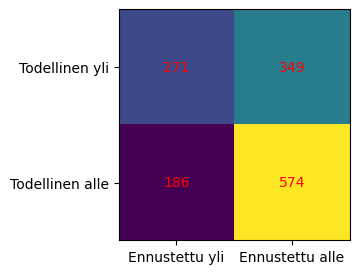

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Ennustettu yli', 'Ennustettu alle'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Todellinen yli', 'Todellinen alle'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [25]:
cof=pd.DataFrame(reg.coef_*100, columns = X.columns).T
cof[0].sort_values(ascending=False)

NameError: name 'reg' is not defined

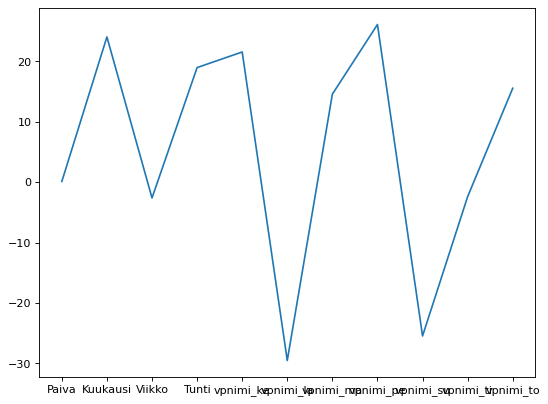

In [ ]:
#kulmakertointen visualisointi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(cof)
plt.show()

In [ ]:
# cross-validate
# number of folds
k = 10
scores = cross_val_score(estimator=reg,
                        X=X,
                        y=y,
                        scoring="accuracy",
                        cv=k)
print("Accuracies from %d individual folds:" % k)
print(scores)
print("Accuracy calculated using %d-fold cross validation = %.3f" % (k, scores.mean()))

c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1

Accuracies from 10 individual folds:
[0.53623188 0.56811594 0.54057971 0.53768116 0.48985507 0.55652174
 0.42173913 0.50144928 0.54927536 0.57619739]
Accuracy calculated using 10-fold cross validation = 0.528


c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1

In [ ]:
# arviointujen ennusteiden laskeminen opetusjoukosta
reg.predict_proba(X_train)

array([[0.39470143, 0.60529857],
       [0.3502667 , 0.6497333 ],
       [0.52875384, 0.47124616],
       ...,
       [0.3933185 , 0.6066815 ],
       [0.4171676 , 0.5828324 ],
       [0.40977769, 0.59022231]])

In [ ]:
#log loss
# arvo ei näytä hyvältä (pitäisi olla välillä 0-1)
from sklearn.metrics import log_loss
#print(Y)
#print(Y_pred)
logloss = log_loss(Y, reg.predict_proba(X))
logloss

c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.8444291773764719

In [ ]:
regdata = pd.DataFrame(reg.predict_proba(X))
regdata

c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\karil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,0,1
0,0.257611,0.742389
1,0.223036,0.776964
2,0.191902,0.808098
3,0.164195,0.835805
4,0.237749,0.762251
...,...,...
6894,0.199805,0.800195
6895,0.434484,0.565516
6896,0.388596,0.611404
6897,0.344601,0.655399


vielä muutamia kuvaajia

ValueError: Could not interpret value `Exercise` for parameter `x`

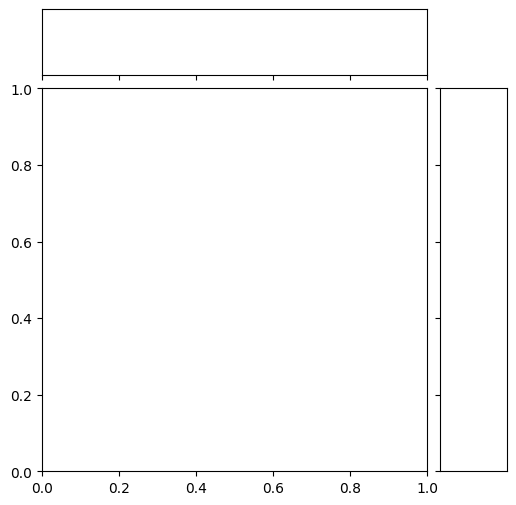

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.jointplot(x='Exercise', y='Stroke', kind="reg", data=df, palette='rainbow')
plt.show()

D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na op

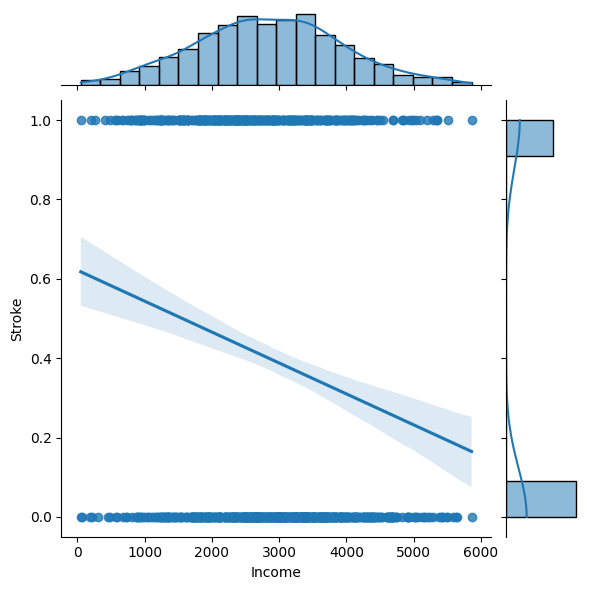

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.jointplot(x='Income', y='Stroke', kind="reg", data=df, palette='rainbow')
plt.show()

D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na op

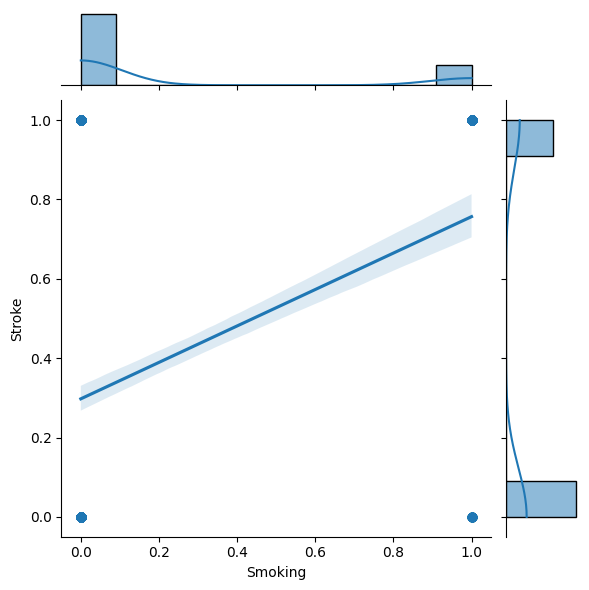

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.jointplot(x='Smoking', y='Stroke', kind="reg", data=df, palette='rainbow')
plt.show()

D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_d

Text(0.5, 1.0, 'Tupakointi ja kohtauksen jakautuminen')

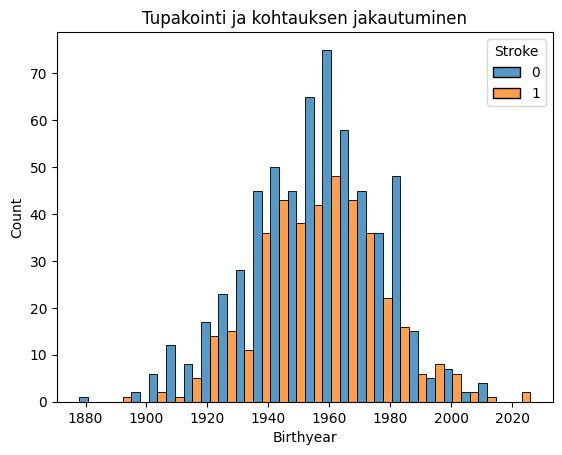

In [ ]:
sns.histplot(
    data=df,
    x="Birthyear", 
    hue="Stroke", 
    multiple="dodge"
).set_title("Tupakointi ja kohtauksen jakautuminen")

D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\Users\kerttuli.ratilainen\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_d

Text(0.5, 1.0, 'Liikunnan ja kohtauksen jakautuminen')

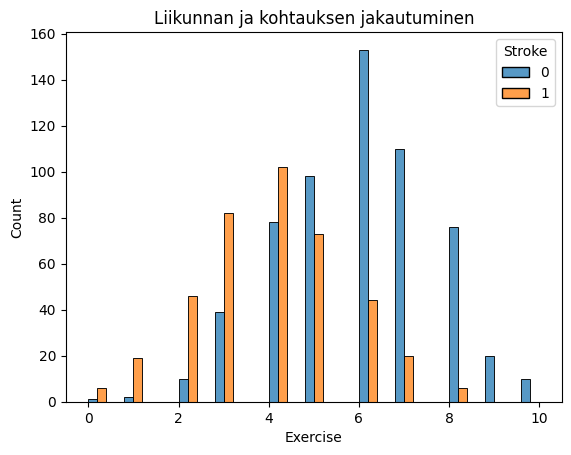

In [ ]:
sns.histplot(
    data=df,
    x="Exercise", 
    hue="Stroke", 
    multiple="dodge"
).set_title("Liikunnan ja kohtauksen jakautuminen")

In [ ]:
corr_matrix = df.corr()
print(corr_matrix)

                Weight   Smoking  Exercise  Cholesterol    Income  \
Weight        1.000000  0.540580 -0.683395     0.577776 -0.248470   
Smoking       0.540580  1.000000 -0.479775     0.443376 -0.186051   
Exercise     -0.683395 -0.479775  1.000000    -0.653835  0.283045   
Cholesterol   0.577776  0.443376 -0.653835     1.000000 -0.420502   
Income       -0.248470 -0.186051  0.283045    -0.420502  1.000000   
Exphappiness -0.499689 -0.321018  0.578967    -0.485000  0.460563   
Birthyear    -0.021473 -0.004205  0.029203    -0.271313  0.294084   
Sex          -0.342178 -0.202763  0.027730    -0.056483  0.024205   
Stroke        0.530595  0.390259 -0.487575     0.410677 -0.172759   

              Exphappiness  Birthyear       Sex    Stroke  
Weight           -0.499689  -0.021473 -0.342178  0.530595  
Smoking          -0.321018  -0.004205 -0.202763  0.390259  
Exercise          0.578967   0.029203  0.027730 -0.487575  
Cholesterol      -0.485000  -0.271313 -0.056483  0.410677  
Income   

<Axes: >

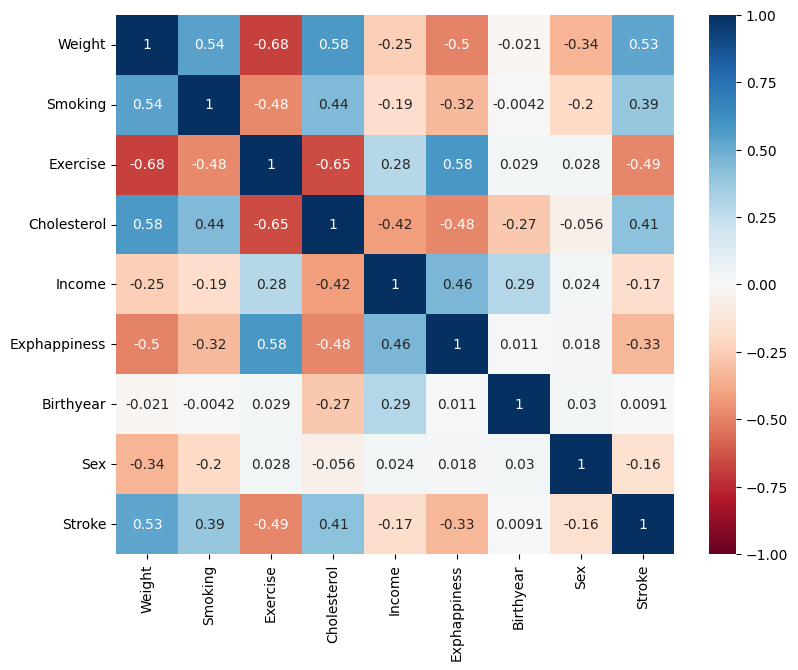

In [ ]:
plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix,vmin=-1.0,vmax=1.0, cmap='RdBu', annot=True)

Lisätehtävä:

tutki esimerkkejä

esim.
https://ebbeberge.github.io/stroke-prediction/ 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8641997/ 